In [3]:
# General Purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

In [4]:
# For modelling
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Load Model

In [3]:
# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model/model.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 168, 64)           8704      
_________________________________________________________________
dropout_1 (Dropout)          (None, 168, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 168, 32)           12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 168, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total para

In [5]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    training_scaled = scaler.fit_transform(dataset)
    return training_scaled

def build_X(training_scaled):
    X_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        X_train.append(training_scaled[i-lookback:i,0])   
        
    X_train = np.array(X_train)
    return X_train

def build_Y(training_scaled):
    Y_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        Y_train.append(training_scaled[i,0])
        
    Y_train = np.array(Y_train)
    return Y_train

## Get data

offset=2546125
offset=2554185

In [11]:
api_data = pd.read_json("https://data.melbourne.vic.gov.au/resource/b2ak-trbp.json?$limit=50000&$offset=2546125")

In [18]:
api_data2 = pd.read_json("https://data.melbourne.vic.gov.au/resource/b2ak-trbp.json?$limit=50000&$offset=2515647")

In [5]:
api_data3 = pd.read_json("https://data.melbourne.vic.gov.au/resource/b2ak-trbp.json?$limit=50000&$offset=2565647")

In [15]:
api_data_train = api_data[api_data['sensor_name']=='Town Hall (West)'].iloc[:,[0,2]]
api_data_test = api_data2[api_data2['sensor_name']=='Town Hall (West)'].iloc[:,[0,2]]
api_data_use = api_data3[api_data3['sensor_name']=='Town Hall (West)'].iloc[:,[0,2]]

In [16]:
# Transformation
sc = MinMaxScaler(feature_range = (0,1))

def transform(api_data_train):
    api_data_train['hourly_counts'] = api_data_train['hourly_counts'].astype(float)
    df_x = api_data_train.set_index(['date_time'])    
    X_test = sc.fit_transform(df_x)
    X_test = build_X(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

In [17]:
def s_transform(data):
    X_test = build_X(data)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

In [18]:
# Make prediction
test_predict = pd.DataFrame(sc.inverse_transform(model.predict(transform(api_data_use)))).clip(lower=0)

In [20]:
test_predict.index = test_predict.index + 168

In [21]:
apt_test = pd.DataFrame(api_data_use.iloc[:,1])
apt_test = apt_test.reset_index(drop=True)

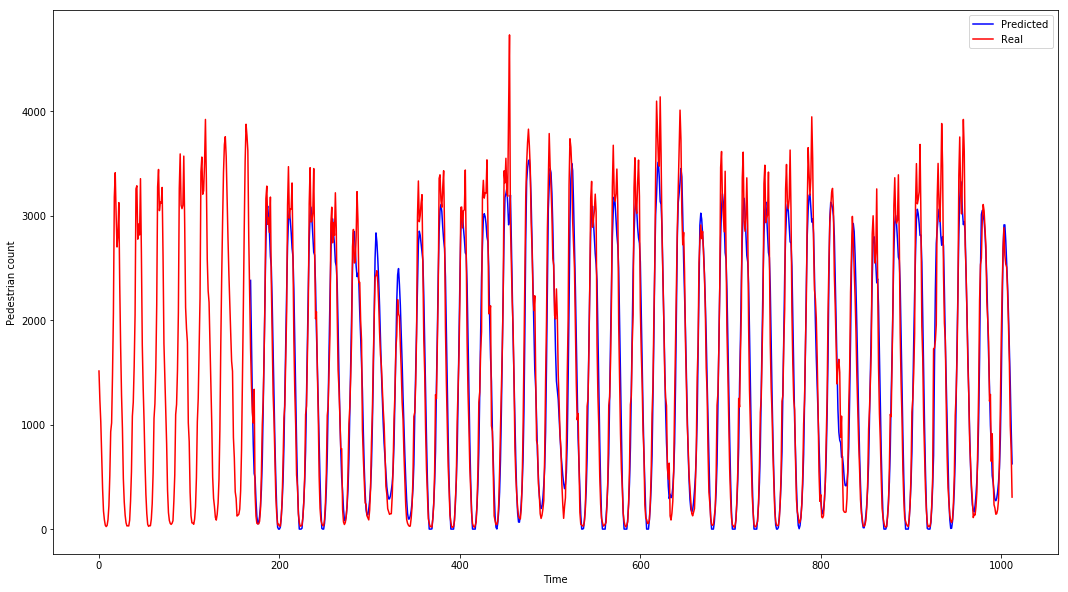

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(18,10))
plt.plot(test_predict.iloc[:,], color = 'blue', label='Predicted')
plt.plot(apt_test.iloc[:,], color = 'red', label='Real')
plt.xlabel('Time')
plt.ylabel('Pedestrian count')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [24]:
rms = sqrt(mean_squared_error(apt_test.iloc[168:1000,], test_predict.iloc[0:832,]))
rms

299.6952389189339

In [25]:
def additional_preds(n_weeks, data):
    # Creates additional 169 predictions (i.e. 1week)
    original = (model.predict(transform(data)))
    
    for i in range(n_weeks):
        onestep = model.predict(s_transform(original)[-169:])
        original = np.concatenate((original, onestep)) # use from last 169

    return pd.DataFrame(sc.inverse_transform(original)).clip(lower=0)

In [42]:
additional = additional_preds(1, api_data_use)

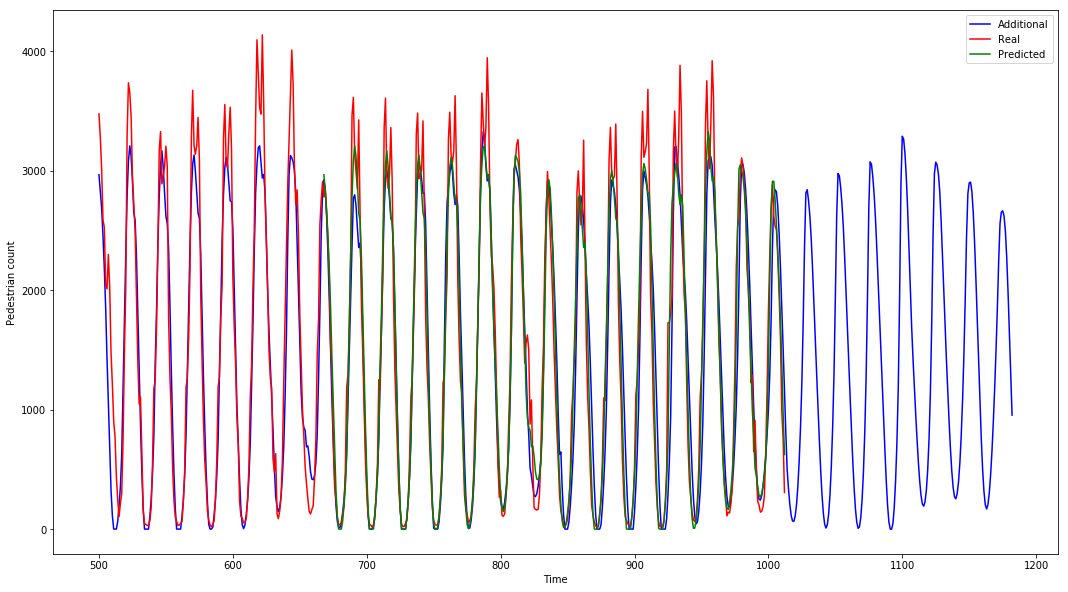

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(18,10))
plt.plot(additional.iloc[500:,], color = 'blue', label='Additional')
plt.plot(apt_test.iloc[500:,], color = 'red', label='Real')
plt.plot(test_predict.iloc[500:,], color = 'green', label='Predicted')

plt.xlabel('Time')
plt.ylabel('Pedestrian count')
plt.legend()
plt.show()

In [28]:
rmse = sqrt(mean_squared_error(apt_test.iloc[0:,], additional.iloc[0:1013,]))
rmse

433.93279398839707

In [38]:
apt_test.tail()

hourly_counts
1008         1962.0
1009         1601.0
1010          990.0
1011          754.0
1012          306.0

In [39]:
api_data_use.tail(5)

date_time  hourly_counts
49755 2019-03-31 19:00:00         1962.0
49804 2019-03-31 20:00:00         1601.0
49853 2019-03-31 21:00:00          990.0
49902 2019-03-31 22:00:00          754.0
49951 2019-03-31 23:00:00          306.0

In [53]:
api_data3.head()

date_time     day  hourly_counts       id  mdate     month  \
0 2019-02-17 19:00:00  Sunday           1513  2566097     17  February   
1 2019-02-17 19:00:00  Sunday            200  2566098     17  February   
2 2019-02-17 19:00:00  Sunday            101  2566099     17  February   
3 2019-02-17 19:00:00  Sunday            301  2566100     17  February   
4 2019-02-17 19:00:00  Sunday            622  2566101     17  February   

   sensor_id                 sensor_name  time  year  
0          4            Town Hall (West)    19  2019  
1         17       Collins Place (South)    19  2019  
2         18       Collins Place (North)    19  2019  
3         53          Collins St (North)    19  2019  
4          2  Bourke Street Mall (South)    19  2019

In [66]:
s_list =api_data3['sensor_id'].unique()
s_list

array([ 4, 17, 18, 53,  2,  1, 15,  9, 10, 12, 11,  8,  5,  6, 14, 26, 24,
       23, 25, 21, 20, 19, 22, 27, 28, 31, 30, 33, 34, 39, 37, 40, 36, 29,
       42, 43, 44, 35, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59])

In [69]:
nweek = 1
counts = []
for i in range(len(s_list)):
    api_data_use = api_data3[api_data3['sensor_id']==s_list[i]].iloc[:,[0,2]]
    ad = additional_preds(nweek, api_data_use)
    print("Sensor:", s_list[i])
    counts.append(ad[-168:])

Sensor: 4
              0
846  340.305054
847  122.367638
848    0.000000
849    0.000000
850    0.000000
851   59.168331
852  191.148132
853  366.751831
854  589.533569
855  885.661865
Sensor: 17
              0
846  441.577026
847  384.951935
848  331.780151
849  286.321930
850  252.690491
851  232.496552
852  224.970276
853  243.283737
854  305.904053
855  523.045471
Sensor: 18
              0
846  334.270233
847  299.574371
848  269.243103
849  243.993713
850  226.549210
851  217.379013
852  215.040543
853  224.595032
854  264.861328
855  447.667847
Sensor: 53
              0
846   99.916283
847   70.665543
848   83.522392
849  122.676773
850  176.936371
851  241.386307
852  310.700409
853  384.834320
854  485.007446
855  652.477905
Sensor: 2
              0
846   14.153949
847    0.000000
848    0.000000
849    0.000000
850    0.000000
851   51.712502
852  199.433289
853  361.321381
854  532.215332
855  726.652527
Sensor: 1
              0
846   73.839661
847    0.000000
848    0.

Sensor: 52
              0
846  154.867661
847   99.489273
848   63.596245
849   47.509186
850   47.613735
851   63.072704
852   89.465179
853  125.791542
854  173.024551
855  262.211884
Sensor: 54
              0
846  175.544159
847  146.432617
848  123.249329
849  108.292786
850   99.294113
851   93.831009
852   91.974915
853   94.871193
854  105.937653
855  140.000839
Sensor: 56
              0
846   98.814499
847   58.075874
848   30.060440
849   16.627048
850   15.932125
851   26.471043
852   47.194836
853   77.719597
854  122.819656
855  193.192612
Sensor: 57
               0
846    92.286110
847     0.000000
848     0.000000
849    79.743233
850   203.368942
851   354.792358
852   518.935913
853   696.844421
854   974.314331
855  1712.674316
Sensor: 58
              0
846  271.718567
847  220.497467
848  198.165115
849  198.959366
850  220.592957
851  255.918304
852  298.433075
853  356.735657
854  475.359161
855  843.791321
Sensor: 59
              0
846  354.523132
847  350.27